## Import libs

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import os
import re
from collections import Counter
from rapidfuzz import process, fuzz

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import word_tokenize, pos_tag

from sklearn.metrics import confusion_matrix
import cv2
import requests
import openpyxl
import xlsxwriter

from TexSoup import TexSoup

from tqdm.autonotebook import tqdm
from typing import (
    Callable,
    Hashable,
    Sequence
)

def ShowImage(ImageList, NameList=None, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt 
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(60, 30))
    # plt.rcParams["figure.figsize"] = [16,9]
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)

        if NameList == None:
            plt.title("Image " + str(i))
        else:
            plt.title(NameList[i])
        plt.axis('off')

    plt.show()

pd.options.plotting.backend = "plotly"
pd.set_option('display.max_colwidth', None)

/var/folders/2z/c11mbd_x6dn12d_ykf68p7gr0000gn/T/ipykernel_1788/1164855884.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Import dataset

In [2]:

file_name = '2k_data_Sep.csv'
if os.name == "nt":
    file_path = r"G:\My Drive\Work\ICM - GE\1. Dataset\2k_sample"

else:
    file_path = '/Users/admin/Library/CloudStorage/GoogleDrive-huypnm@galaxy.com.vn/My Drive/Work/ICM - GE/1. Dataset/2k_sample'

data_path = os.path.join(file_path, file_name)

data = pd.read_csv(data_path)
data.describe(include='all')

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
count,2000.000000,2000,2000,2000,2000,2000,2000,2000
unique,NaN,1957,1832,2,3,2,1965,1833
top,NaN,6. Viết tập hợp các số tự nhiên \( x \) thoả mãn mỗi điều kiện sau:\na) \( x \leq 6 \);\nb) \( 35 \leq x \leq 39 \);\nc) \( 216<x \leq 219 \),1.13. Viết thêm các số liền trước và số liền sau của hai số 3532 và 3529 để được sáu số tự nhiên rồi sắp xếp sáu số đó theo thứ tự từ bé đến lớn.,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/66ead790-336a-11ed-afcb-abad28552b30,https://s3.stag.icankids.com.vn/uploads/question/4cd6c4f0-9e18-11ec-bad9-1d3098bb5545
freq,NaN,6,8,1000,877,1021,6,8
mean,7161.704500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1589.314896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4416.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5811.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7125.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8492.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
if os.name == 'nt':
    image_path = r"G:\My Drive\Work\ICM - GE\1. Dataset\temp_images"
else:
    image_path = '/Users/admin/Library/CloudStorage/GoogleDrive-huypnm@galaxy.com.vn/My Drive/Work/ICM - GE/1. Dataset/temp_images'

In [4]:
excel_name = 'NOT_MATCH_data.xlsx'
excel_path = os.path.join(file_path, excel_name)

open_workbook = openpyxl.load_workbook(excel_path)
sheets = open_workbook.sheetnames

df_xl = pd.read_excel(
    excel_path,
    engine="openpyxl",
    sheet_name=sheets[0],
    index_col=False,
)


In [5]:
df_xl = df_xl[['Feedback ID', 'lookup_in_question']]

In [6]:
df_xl['lookup_in_question'][df_xl['lookup_in_question'] == 0] = '0'

In [7]:
data = pd.merge(data, df_xl, how='left', on='Feedback ID')

## TODO

[x] Seperate formula and text

[x] Tokenize text

[x] Apply methods:

- [x] Cosine similarity (might need full Q-A pair to replicate product line)
- [x] Leveshtein
- [] Jaccard
- [] Gensim

[x] Handle formula

[] Merge formula and text in form of....

In [8]:
def handle_formula(t:str):
    """
        Function that split a text that contain both text and formula(in Latex form)

        Args:
            t (str): a string type input

        Returns:
            t (str): a string contain only text
            formulas (list): a list contain all possible formula 
    """
    s = t
    text_string = t
    formulas = []
    # math_operators =["+", "-", "*", "/", "=", "<", ">"]
    begin = s.find("\(") 
    # if s.find("\(") != -1 else s.find("\[")
    math_expression_bracket = [
        ["\(", "\)"],
        # ["\[", "\]"]
    ]
    for bracket in math_expression_bracket:
        temp_s = s 
        begin = temp_s.find(bracket[0])

        while begin != - 1:
            begin, end = temp_s.find(bracket[0]), temp_s.find(bracket[1])
            formula = temp_s[begin:end + 2]
            if begin != -1:
                formulas.append(formula)

            temp_s = temp_s[end+2:]

    for math_expression in formulas:
        text_string = "".join(text_string.split(math_expression))

    return text_string, formulas

# ===================================================================
def clean_string_v1(t:str, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    table = str.maketrans(filters, len(filters)*" ")
    t = t.translate(table)
    t = re.sub(r'\d+', '', t) # Remove number
    return word_tokenize(t.lower(), format='text')

# ===================================================================
def to_raw_string(s:str):
    """
        Return a raw string
    """
    escape_dict={
       '\a':r'\a',
       '\b':r'\b',

    #    '\r':r'\r',
    #    '\n':r'\n',
    #    '\t':r'\t',

       '\f':r'\f',
       '\v':r'\v',
       '\'':r'\'',
       '\"':r'\"','\0':r'\0','\1':r'\1','\2':r'\2','\3':r'\3','\4':r'\4','\5':r'\5','\6':r'\6','\7':r'\7','\8':r'\8','\9':r'\9'
        }
    raw_s = ''
    for char in s:
        try: raw_s += escape_dict[char]
        except KeyError: raw_s += char
    return raw_s

# ===================================================================
def strip_latex(t:str):
    sequence_text = TexSoup(t).text
    return " ".join(sequence_text)

# ===================================================================
def apply_filter(t:str, filter=r"(?ui)\W"):
    """
        Apply filter to keep number and character
    """
    r = re.compile(filter)
    str_out = r.sub(" ", t)
    return str_out

# ===================================================================
def create_phrase(t:str):
    return word_tokenize(t, format='text')

# ===================================================================
def sequence_of_text(s:str):
    """
        Clean string, return string only contain text
    """
    text, _ = handle_formula(s) # Extract text part
    r_text = to_raw_string(text) # Convert string to raw string to keep some escape character
    non_latex_str = strip_latex(r_text) # Strip latex symbol
    filtered_str = apply_filter(non_latex_str) # Apply filter keep number and char
    str_out = create_phrase(filtered_str) # Create phrase using 'underthesea'
    return " ".join(str_out.split()).lower() # Remove duplicate space

# ===================================================================
def sequence_of_formula(s:str):
    """
        Clean string, return sequence of formulas
    """
    _, formulas = handle_formula(s)
    formula_out = []
    for formula in formulas: # Loop over single formula
        r_formula = to_raw_string(formula)
        fixed_formula = handle_formula_exception(r_formula) # Fix some exception error when using TexSoup (doesn't cover all cases)
        try:
            non_latex_formula = strip_latex(fixed_formula) # Try strip latex symbol
        except TypeError:
            non_latex_formula = clean_math_symbol(fixed_formula) # If fail, striping simple character '()[\]{|}'
        formula_out.append(
            " ".join(non_latex_formula.split()).lower() # Remove duplicate space
        )
    return formula_out

# ===================================================================
def clean_math_symbol(formula:str, filters='()[\]{|}'):
    table = str.maketrans(filters, len(filters)*" ")
    formula = formula.translate(table)
    return formula

# ===================================================================
def handle_formula_exception(formula:str):
    """
        Handle special case before stripping latex symbol
    """
    cases = [
        'left(', 
        'right)']
    formula_split = formula.split()
    result_split = []

    for element in formula_split:
        if any(case in element for case in cases):
            for case in cases:
                running_ele = element
                possible_idx = []
                idx_find = running_ele.find(case)
                while idx_find != -1:
                    idx_find = running_ele.find(case)
                    if idx_find != -1:
                        possible_idx.append(idx_find)
                    running_ele = running_ele[idx_find + len(case):]

                element = ''.join(
                    [
                        element[:idx + len(case)] + " " + element[idx + len(case):] for idx in possible_idx
                    ]) if len(possible_idx) != 0 else element
                    
        result_split.append(element)
    return ' '.join(result_split)

# ===================================================================
def preprocess_text(s:str):
    """
        Retrieve text from entire string contain both formula
    """
    text, _ = handle_formula(s)
    text = clean_string_v1(text)
    return text
    
# ===================================================================
def preprocess_formula(s:str):
    """
        Retrieve formula from entire string contain both formula and text 
    """
    _, formulas = handle_formula(s)
    return formulas

# ===================================================================
def calculate_ratio(s:str, processor_opt:str='old',opt:str='text'):
    """
        Return ratio between text and math expression
    """
    if processor_opt == 'new':
        text_measure = sequence_of_text(s)
        formulas = sequence_of_formula(s)

    else:
        text, formulas = handle_formula(s)

        text_measure = clean_string_v1(text)

    formula_measure = " ".join(formulas)

    if opt == 'text':
        return len(text_measure) / (len(text_measure) + len(formula_measure) + 10e-9) # Prevent division by zero error

    else:
        return len(formula_measure) / (len(text_measure) + len(formula_measure) + 10e-9) # Prevent division by zero error 

# ===================================================================
def text_analyze_v2(s:str, idx, word_dict, processor_opt:str='old'):
    """
        Analyze string text and return it's case

        Args:
            s (str): a string type text
        Returns
            A string type indicate which kind the text belong to
            "Math only"
            "Text only"
            "Math and Text"
    """
    if processor_opt == 'new':
        try:
            text_strings = sequence_of_text(s)
            formulas = sequence_of_formula(s)
        except TypeError:
            print("Check Feedback ID {}".format(idx))
    else:
        text, formulas = handle_formula(s)
        text_strings = clean_string_v1(text)
    # formula_strings = " ".join(formulas)
    # This will take 'Text only' case
    if len(formulas) == 0:
        return "Text only"

    token_words = text_to_sequence(s, word_dict)
    # This will take "Math only" case
    if (
        # When string is empty
        str.isspace(text_strings) or 
        # When formulas length outnumber text length
        len(token_words) < len(formulas) * 2 or 
        # When only 1 type of token exist
        len(set(token_words)) <= 1):
        return 'Math only'

    return "Math and Text"

# ===================================================================
def text_analyze_v1(s:str, word_dict:dict):
    """
        Analyze string text and return it's case

        Args:
            s (str): a string type text
        Returns
            A string type indicate which kind the text belong to
            "Math only"
            "Text only"
            "Math and Text"
    """
    text, formulas = handle_formula(s)
    text_measure = clean_string_v1(text)
    formula_measure = " ".join(formulas)
    # This will take 'Text only' case
    if len(formulas) == 0:
        return "Text only"

    token_words = text_to_sequence(s, word_dict)
    # This will take "Math only" case
    if (
        # When string is empty
        str.isspace(text_measure) or 
        # When number of formula outnumber number of token
        len(token_words) < len(formulas) or
        # When only 1 type of token exist
        len(set(token_words)) <= 1):
        return 'Math only'

    return "Math and Text"

# ===================================================================
def create_dict(df, normalization:bool=True):
    """
        Create dictionary of words from corpus

        Args:
            corpus (list): list contain Latex strings
            normalization (bool) : if True will using tf-idf weighted to normalize dictionary 
        Returns:
            a dictionary type contain all token words
    """
    vocab_corpus = []
    for _, row in df.iterrows():
        try:
            lookup_token = tokenize(row['Lookup Text'])
            question_token = tokenize(row['Question Text'])
            vocab_corpus.extend(lookup_token)
            vocab_corpus.extend(question_token)
        except:
            print("Check Feedback ID {}".format(row['Feedback ID']))

    vocab_corpus = sorted(set(vocab_corpus))
    dict_vocab = {j: i for i, j in enumerate(vocab_corpus, start=0)}

    if normalization:
        norm_vectorize = dict_normalization(df, vocab_corpus)
        for index, key in enumerate(dict_vocab):
            dict_vocab[key] = norm_vectorize[index]

    return dict_vocab

# ===================================================================
def dict_normalization(df:pd.DataFrame, word_dict:dict, preprocess_opt='old'):
    """ 
        Return a dictionary normalized by Tf-Idf
    """
    corpus = df['Lookup Text'].tolist() + df['Question Text'].tolist()
    if preprocess_opt=='old':
        corpus = [preprocess_text(sentence) for sentence in corpus]

    else:
        corpus = [sequence_of_text(sentence) for sentence in corpus]
    
    vectorizer = TfidfVectorizer(analyzer='word', min_df=0, vocabulary=word_dict).fit(corpus)
    # norm_values = vectorizer.toarray().std(axis=0)
    # return {i:j for i, j in zip(word_dict, norm_values)}
    return vectorizer.idf_


# ===================================================================
def tokenize(s:str, processor_opt:str='old',filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    """
        Tokenize a string into a list of string

        Args:
            s (str): Latex string
            filters (str): String stopword

        Returns:
            list : contain all string words (exclude math expression) being splitted from the original text
    """
    if processor_opt == 'new':
        t = sequence_of_text(s)
        sequence_out = t.split()

    else:
        t = preprocess_text(s)
        sequence_out = clean_string_v1(t, filters).split()

    return sequence_out

# ===================================================================
def text_to_sequence(t:str, word_dict:dict | None=None, processor_opt='old'):
    """
        Convert string of words into list of index from dictionary

        Args:
            t (str): string of words
            word_dict (dict): dictionary of words

        Returns:
            list of index words in original string
    """
    # After cleaned, split into char level
    token_words = tokenize(t, processor_opt)

    if word_dict != None:
        sequence = list(map(lambda x: word_dict.get(x, -1), token_words))

    else:
        sequence = token_words

    return sequence

In [9]:
# ===================================================================
def crawls_image(url, path , img_name='temp_1'):
    """
        Image crawling from url only use requests
        Source: https://stackoverflow.com/a/30229298/9434756
    """
    image_path = os.path.join(path, f'{img_name}.jpg')

    with open(image_path, 'wb') as handle:
        response = requests.get(url, stream=True)

        if not response.ok:
            print(response)

        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)
    
    img = cv2.imread(image_path)

    return img

# ===================================================================
def request_API(payload, post_url='https://data-checking.herokuapp.com/data-checking'):
    r = requests.post(post_url, {'image': payload})
    return r.text

In [10]:
# ===================================================================
def compare_2_sentences(t_1:str, t_2:str, word_dict: dict, metric="Cosine"):
    """
        Return cosine similarity scores of 2 sentences

    """
    # Remove formula
    t_1 = preprocess_text(t_1)
    t_2 = preprocess_text(t_2)
    if metric == "L":
        return fuzz.ratio(t_1, t_2)
    # Convert string to sequence of index in dictionary
    seq_1 = text_to_sequence(t_1, word_dict)
    seq_2 = text_to_sequence(t_2, word_dict)

    max_len = max(len(seq_1), len(seq_2))
    
    # If either seq_1 and seq_2 have nothing inside, return 0
    if len(seq_1) == 0 or len(seq_2) == 0:
        return 0
        
    seq_1 = seq_1 + [0] * (max_len - len(seq_1))
    seq_2 = seq_2 + [0] * (max_len - len(seq_2))

    return cosine_similarity(np.array([seq_1]), np.array([seq_2]))[0][0]

# ===================================================================
def compare_2_formula(
    l_1, 
    l_2,
    processor:Callable[..., Sequence[Hashable]] | None | bool=False
    ):
    """
        Compare 2 list of formula, only support for Levenshtein distance methods
    """
    levenshtein_scores = []
    for _, formula in enumerate(l_1):
        match_pair = process.extract(formula, l_2, scorer=fuzz.WRatio, limit=1)
        if len(match_pair) > 0 :
            levenshtein_scores.append(match_pair[0])
    
    if len(levenshtein_scores) == 0:
        return 0
        
    ls = np.array(levenshtein_scores)[:,1].astype('float') / 100

    return ls.mean()

# ===================================================================
def search_engine_v1(target, source, word_dict, top_n = 1):
    """
        Return result match with target and score

        Args:
            target (str): string text target
            source (pd.DataFrame): Dataframe contain: ['Question Text', 'Question Token', 'Question Formula']
            top_n (int): Number of match result return

        Returns:
            Match string & scores
    """
    max_len = max_len_sequence(source['Question Token'])
    target_token = text_to_sequence(target, word_dict)
    target_token = sequence_padding(target_token, word_dict, max_len)

    # Get formula scores
    target_formula = preprocess_formula(target)
    # An actual string
    if len(set(target_token)) > 2:
        text_scores = cosine_similarity(
                                np.array([target_token]), 
                                np.array(source['Question Token'].tolist())
                                )
        result_df = pd.concat([source, pd.DataFrame(text_scores[0], columns=['Text scores'])], axis=1)

        if len(target_formula) == 0:
            result_df['Final scores'] = result_df['Text scores']
            result_df['Formula scores'] = 0

        else:
            result_df['Formula scores'] = result_df['Question Formula'].apply(
                lambda x: compare_2_formula(target_formula, x))
                
            # Aggregate both score
            # Ignore 0 value why calculating mean, so that if only either Formula or Text appear
            # It'll not being penalty for other score equal 0
            temp_df = result_df[['Text scores', 'Formula scores']].copy()
            temp_df = temp_df.replace(0, np.NaN)

            result_df['Final scores'] = temp_df.mean(axis=1).fillna(0)

        r_index = result_df['Final scores'].argsort()[::-1][:top_n]

    else:
        formula_scores = source['Question Formula'].apply(
                lambda x: compare_2_formula(target_formula, x))

        result_df = pd.concat([source, pd.DataFrame(formula_scores.tolist(), columns=['Formula scores'])], axis=1)
        r_index = formula_scores.argsort()[::-1][:top_n]

        result_df['Final scores'] = result_df['Formula scores']
        result_df['Text scores'] = 0

    result_df = result_df.iloc[r_index]
    result_df.reset_index(inplace=True, drop=True)
    
    return result_df[['Question Text', 'Text scores', 'Formula scores', 'Final scores', 'Question Image']]

# ===================================================================
def search_engine_v2(target, source, word_dict, preprocess_opt='old',top_n = 1):
    """
        Return result match with target and score

        Args:
            target (str): string text target
            source (pd.DataFrame): Dataframe contain: ['Question Text', 'Question Token', 'Question Formula']
            top_n (int): Number of match result return

        Returns:
            Match string & scores
    """
    if preprocess_opt == 'old':
        target_text = preprocess_text(target)
        target_formula = preprocess_formula(target)
    else:
        target_text = sequence_of_text(target)
        target_formula = sequence_of_formula(target)
    target_token = text_to_sequence(target, word_dict)

    # Get formula scores
    source.reset_index(inplace=True, drop=True) # Reset index to make sure index in the right order
    if len(set(target_token)) > 1:
        # Search for matching string
        text_scores = np.array(process.extract(
            target_text,
            source['Cleaned Question'],
            scorer=fuzz.WRatio,
            limit=len(source['Cleaned Question'])
        ))
        
        scores = text_scores[:, 1].astype('float')
        idx = text_scores[:,2].astype('int')
        df_text_scores = pd.DataFrame(scores / 100, index=idx, columns=['Text scores']).sort_index()

        result_df = pd.concat(
            [source, 
            df_text_scores
            ], 
            axis=1)
        # Text only
        if len(target_formula) == 0:
            result_df['Final scores'] = result_df['Text scores']
            result_df['Formula scores'] = 0
        # Math & Text
        else:
            result_df['Formula scores'] = result_df['Question Formula'].apply(
                lambda x: compare_2_formula(target_formula, x, 
                processor=True if preprocess_opt =='old' else False))
            # Aggregate both score
            # Ignore 0 value why calculating mean, so that if only either Formula or Text appear
            # It'll not being penalty for other score equal 0
            temp_df = result_df[['Text scores', 'Formula scores']].copy()
            temp_df = temp_df.replace(0, np.NaN)
            result_df['Final scores'] = temp_df.mean(axis=1).fillna(0)

        r_index = result_df['Final scores'].argsort()[::-1][:top_n]

    else:
        # Math only
        # Get formula scores
        formula_scores = source['Question Formula'].apply(
                lambda x: compare_2_formula(target_formula, x,
                processor=True if preprocess_opt =='old' else False))

        result_df = pd.concat([source, pd.DataFrame(formula_scores.tolist(), columns=['Formula scores'])], axis=1)
        r_index = formula_scores.argsort()[::-1][:top_n]

        result_df['Final scores'] = result_df['Formula scores']
        result_df['Text scores'] = 0

    result_df = result_df.iloc[r_index]
    result_df.reset_index(inplace=True, drop=True)

    return result_df[['Question Text', 'Text scores', 'Formula scores', 'Final scores', 'Question Image']]

# ===================================================================
def apply_SE(df, df_source, word_dict, search_engine, use_label=False):
    df_r = df.copy()
    df_r.insert(3, "search_text", '')
    df_r.insert(4, 'text_scores', '')
    df_r.insert(5, 'formula_scores', '')
    df_r.insert(6, "final_scores", '')
    df_r.insert(7, 'search_image', '')

    progress_bar = tqdm(df_r["Lookup Text"])
    for i, string in enumerate(progress_bar):
        if use_label: source = pd.DataFrame(df_source.iloc[i]).T
        else: source = df_source
        search_result = search_engine(string, source, word_dict)
        (
            df_r.loc[i,"search_text"], 
            df_r.loc[i,'text_scores'],
            df_r.loc[i,'formula_scores'],
            df_r.loc[i,"final_scores"],
            df_r.loc[i,'search_image']
        ) = (
            search_result["Question Text"].to_numpy()[0], 
            search_result["Text scores"].to_numpy()[0],
            search_result["Formula scores"].to_numpy()[0],
            search_result["Final scores"].to_numpy()[0],
            search_result["Question Image"].to_numpy()[0]
        )
        df_r.loc[i, "SE_match"] = 'MATCH' if (
            df_r.loc[i, 'search_text'] == df_r.loc[i, "Question Text"] or
            df_r.loc[i, 'search_text'] == df_r.loc[i, "Lookup Text"]
        ) else "NOT MATCH"

        progress_bar.set_description(
            "Sample {}/{}".format(i+1, len(df_r["Lookup Text"]))
        )
        progress_bar.update()

    return df_r

# ===================================================================
def max_len_sequence(source, max_len=800):
    """
        Get max length of all sequences
    """
    return max(source.str.len().max(), max_len)

# ===================================================================
def sequence_padding(l_t, word_dict, max_len=800):
    """
        Padding list of tokens
    """
    if isinstance(list(word_dict.values())[0], float):
        l_t += [0] * (max_len - len(l_t)) # Return padding = 0 if dictionary was normalize

    else:
        l_t += [-1] * (max_len - len(l_t)) # Return padding = -1 if dictionary wasn't normalize

    return l_t

# ===================================================================
def create_source(ds:pd.DataFrame, word_dict: dict, preprocess_opt='old'):
    """
        Create source dataframe for Search Engine

        Args:

        Returns: 
            pd.DataFrame contain ['Question Text', 'Question Token', 'Question Formula']
    """
    df_s = pd.DataFrame(ds)
    df_s['Cleaned Question'] = df_s['Question Text'].apply(
        lambda x: sequence_of_text(x) if preprocess_opt=='new' else preprocess_text(x)
    )
    df_s['Question Formula'] = df_s["Question Text"].apply(
        lambda x: sequence_of_formula(x) if preprocess_opt=='new' else preprocess_formula(x)
    )

    df_s["Question Token"] = df_s["Question Text"].apply(
        lambda x: text_to_sequence(x, word_dict)
    )

    # max_len = max_len_sequence(df_s['Question Token'])
    # df_s['Question Token'] = df_s['Question Token'].apply(lambda x: sequence_padding(x, word_dict, max_len))

    return df_s

## Create dictionary

In [11]:
df_text = data[['Feedback ID', 'Lookup Text', 'Question Text']].copy()
# total_q = data["Question Text"].tolist()
dictionary = create_dict(df_text)
len(dictionary)

6748

## Preprocess

In [12]:
# Retrieve token from string text
data["token_lookup"] = data["Lookup Text"].apply(lambda x: text_to_sequence(x, dictionary))
data["token_question"] = data["Question Text"].apply(lambda x: text_to_sequence(x, dictionary))

data["word_lookup"] = data["token_lookup"].apply(lambda x: len(x))
data["word_question"] = data["token_question"].apply(lambda x: len(x))

In [13]:
# Analyze if string contain only 'Text' or only 'Formula' or contain Both
data["lookup_kind"] = data.apply(
    lambda x: text_analyze_v2(x['Lookup Text'], x['Feedback ID'], dictionary), axis=1)
data["question_kind"] = data.apply(
    lambda x: text_analyze_v2(x["Question Text"], x['Feedback ID'],dictionary), axis=1)

In [14]:
df_s = create_source(data[["Question Text",'Question Image']], dictionary)

In [15]:
# data_r_v1 = apply_SE(data, df_s, dictionary, search_engine_v1)
data_r_v2 = apply_SE(data, df_s, dictionary, search_engine_v2)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
data_test = apply_SE(data, df_s, dictionary, search_engine_v2, use_label=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
data = data_r_v2

In [18]:
data.columns

Index(['Feedback ID', 'Lookup Text', 'Question Text', 'search_text',
       'text_scores', 'formula_scores', 'final_scores', 'search_image',
       'Feedback Type', 'Feedback Result', 'Human Feedback', 'Lookup Image',
       'Question Image', 'lookup_in_question', 'token_lookup',
       'token_question', 'word_lookup', 'word_question', 'lookup_kind',
       'question_kind', 'SE_match'],
      dtype='object')

## Check
- Summary: Number of word between MATCH and NOT MATCH
- Detail: Number of word between MATCH and NOT MATCH

In [19]:
"""
    Detail
"""
m = data[data["Human Feedback"]== "MATCH"]
m.reset_index(inplace=True, drop=True)

nm = data[data["Human Feedback"] == "NOT MATCH"]
nm.reset_index(inplace=True, drop=True)

m_n_t_data = data[(data['lookup_kind'] == 'Math and Text') & (data['question_kind'] == 'Math and Text')]
m_n_t_data.reset_index(inplace=True, drop=True)

m_o_data = data[(data['lookup_kind'] == 'Math only') & (data['question_kind'] == 'Math only')]
m_o_data.reset_index(inplace=True, drop=True)

t_o_data = data[(data['lookup_kind'] == 'Text only') & (data['question_kind'] == 'Text only')]
t_o_data.reset_index(inplace=True, drop=True)

In [20]:
"""
    Summary string type
"""
fig = px.histogram(
    data, x=["lookup_kind", "question_kind"], text_auto=True, 
    barmode='group'
    )
fig.update_layout(title_text="Total number of each kind")
fig.show()

In [21]:
m_n_t_offset = data[
    (data['lookup_kind'] != 'Math and Text') & (data['question_kind'] == 'Math and Text')
]
m_n_t_offset.reset_index(inplace=True, drop=True)

m_o_offset = data[
    (data['question_kind'] != 'Math only') & (data['lookup_kind'] == 'Math only')
]
m_o_offset.reset_index(inplace=True, drop=True)

t_o_offset = data[
    (data['lookup_kind'] == 'Text only') & (data['question_kind'] != 'Text only')
]
t_o_offset.reset_index(inplace=True, drop=True)

In [23]:
visual_data = data_test
test_m = visual_data[
    (visual_data['Human Feedback'] == 'MATCH') 
    ]
test_m.reset_index(inplace=True, drop=True)

test_m_m = test_m[
    (test_m['SE_match'] == 'MATCH')
    ]
test_m_m.reset_index(inplace=True, drop=True)

test_m_nm = test_m[
    (test_m['SE_match'] == 'NOT MATCH')
    ]

test_m_nm.reset_index(inplace=True, drop=True)

test_nm = visual_data[
    visual_data['Human Feedback'] == 'NOT MATCH'
    ]
test_nm.reset_index(inplace=True, drop=True)
fig = ff.create_distplot([
                    np.array(test_m['final_scores'], dtype=float), 
                    np.array(test_nm['final_scores'], dtype=float)], 
                        group_labels=["MATCH", "NOT MATCH"], 
                        bin_size=.0125,
                        # histnorm= '',
                        curve_type='normal',
                        show_curve=True
                        )
fig.update_layout(title_text="Levenshtein distance distribution on total data")
fig.show()

In [24]:
test_nm['lookup_in_question'][
    (test_nm['lookup_in_question'] == 'x') |
    (test_nm['lookup_in_question'] == 'v')
] = 'lookup_in_question'

test_nm['lookup_in_question'][
    (test_nm['lookup_in_question'] == '0') 
] = 'lookup_NOT_in_question'

test_nm['lookup_in_question'].value_counts()

lookup_NOT_in_question    726
lookup_in_question        253
Name: lookup_in_question, dtype: int64

In [25]:
nm_l_in_q = test_nm[
    (test_nm['lookup_in_question'] == 'lookup_in_question') 
]
nm_l_not_in_q = test_nm[
    test_nm['lookup_in_question'] == 'lookup_NOT_in_question'
]

In [26]:
fig = px.histogram(
    test_nm, x=['lookup_in_question'], text_auto=True, 
    barmode='group'
    )
fig.update_layout(title_text="Total number of lookup in or not in question")
fig.show()

In [27]:
fig = ff.create_distplot([
                    np.array(nm_l_in_q['final_scores'], dtype=float), 
                    np.array(nm_l_not_in_q['final_scores'], dtype=float)], 
                        group_labels=["Lookup in Question", "Lookup NOT in Question"], 
                        bin_size=.0125,
                        # histnorm= '',
                        curve_type='normal',
                        show_curve=True
                        )
fig.update_layout(title_text="Lookup in Question score distribution")
fig.show()

In [122]:
# test_batch = data[
#     (data['lookup_kind'] == 'Math only') &
#     (data['lookup_kind_v1'] == 'Math and Text')
# ]
# test_batch = nm_l_not_in_q[nm_l_not_in_q['final_scores'] > 0.97]
test_batch = nm_l_in_q[nm_l_in_q['final_scores'] < 0.5]
# test_batch = nm[nm['final_scores'] > 0.9]
# test_batch = data[data['Feedback ID']==9289]
# test_batch = test_m_nm
i = 0

1

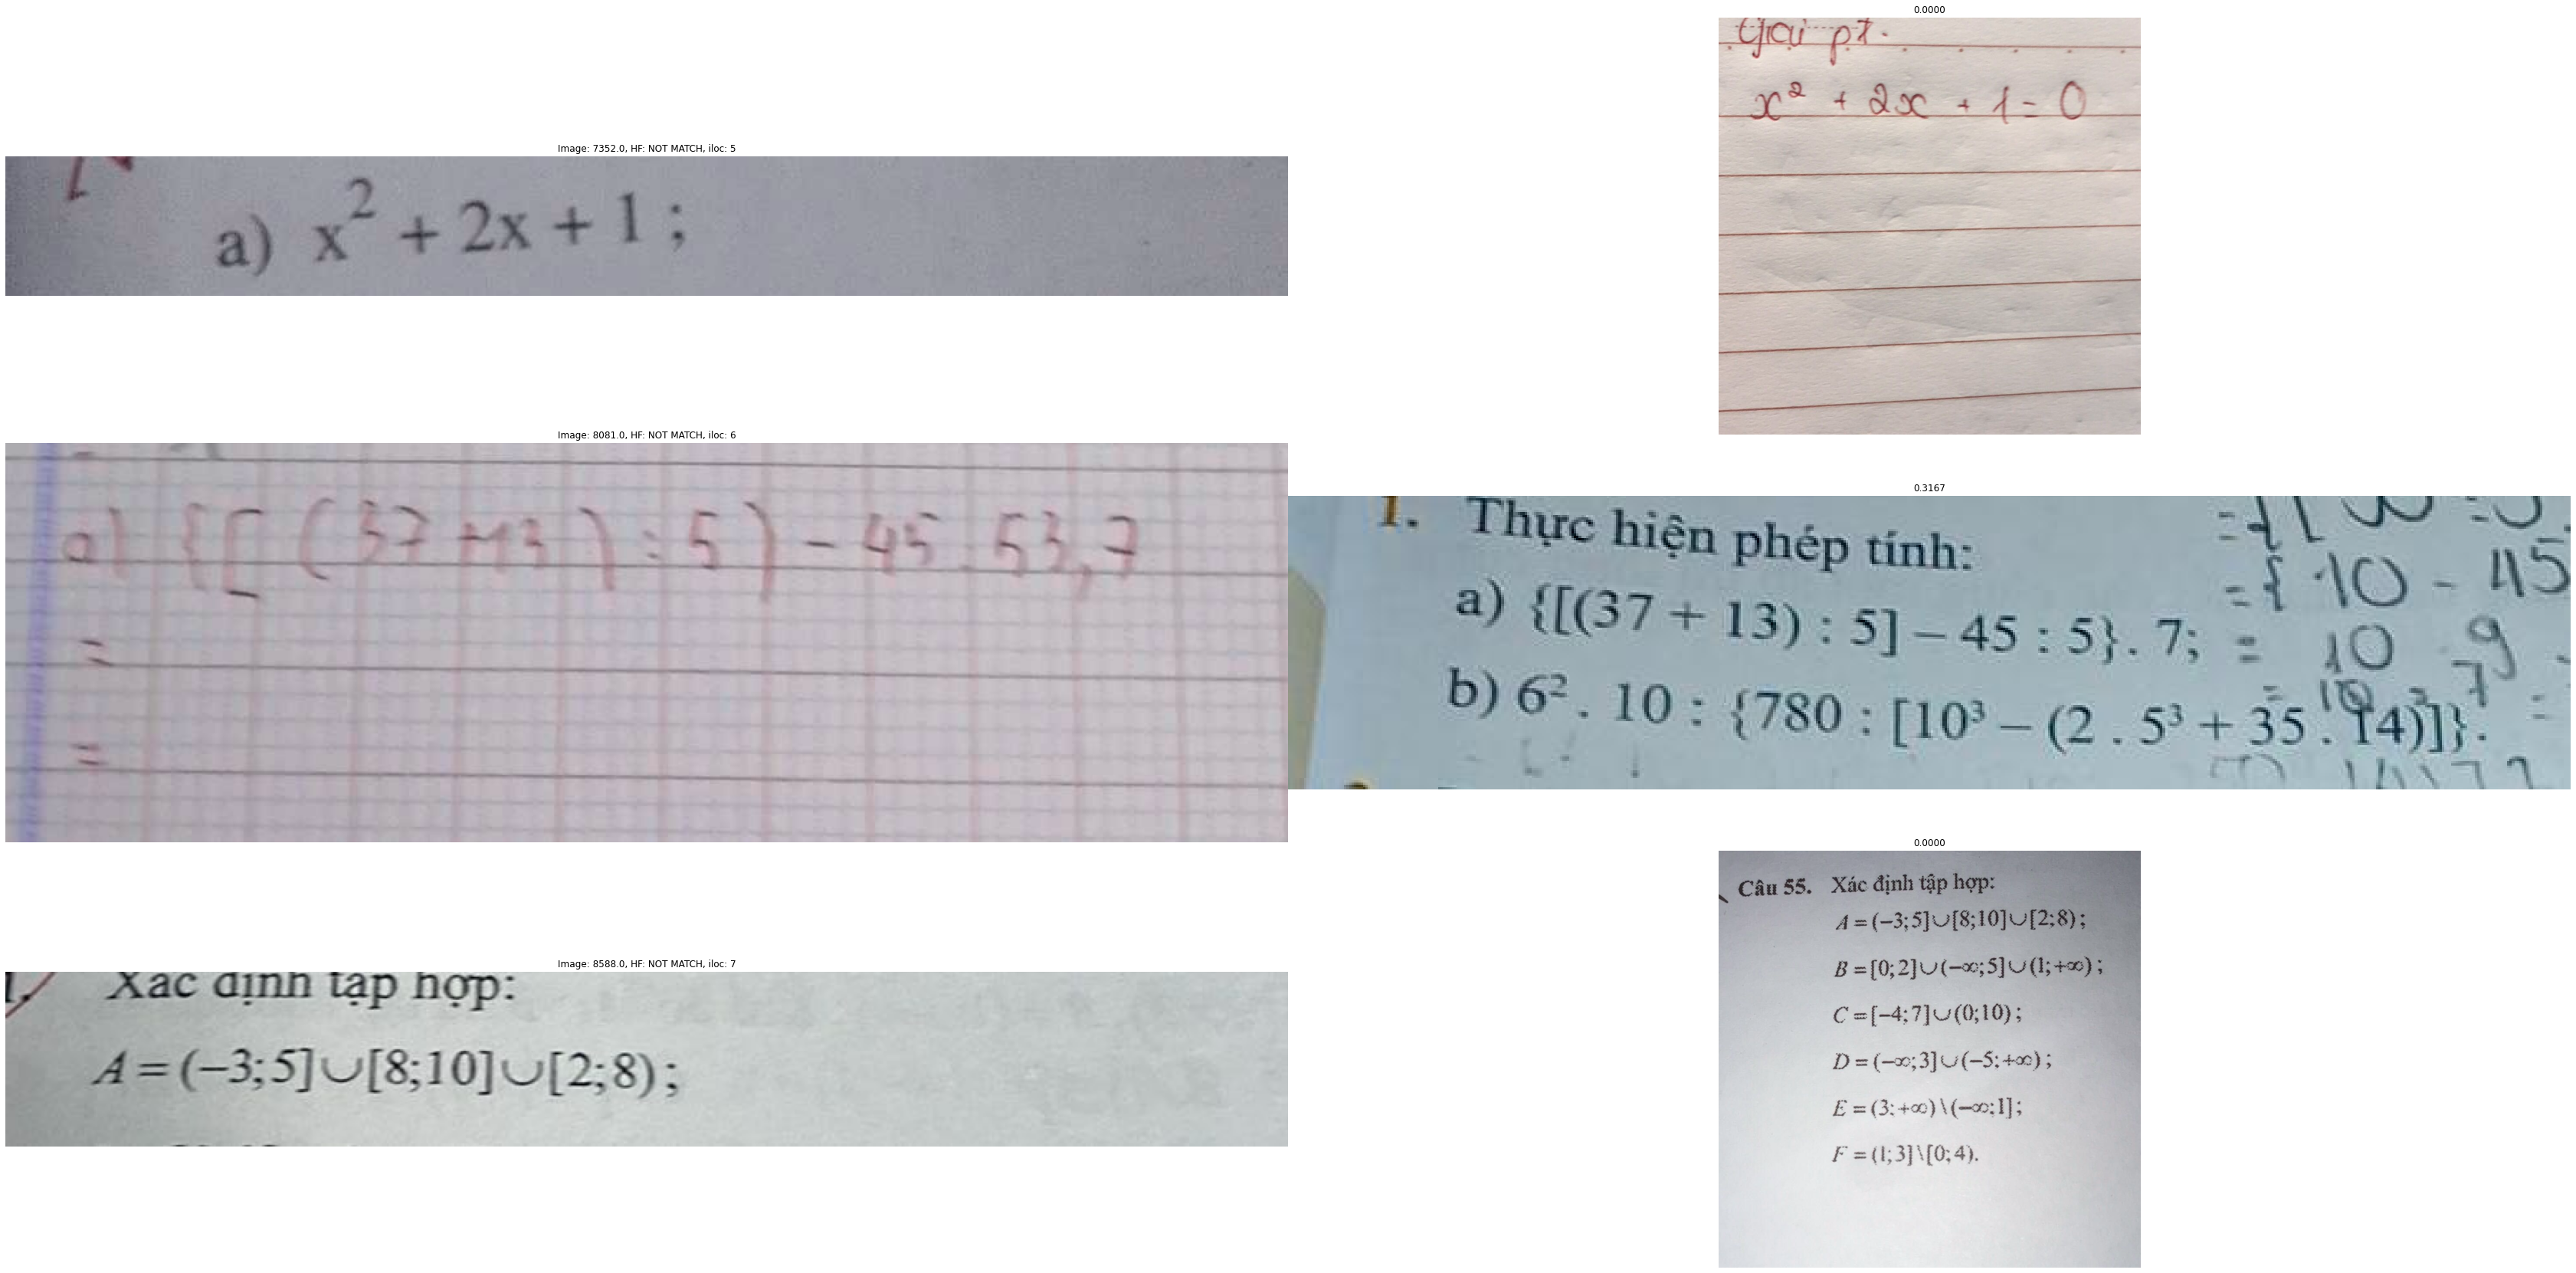

In [124]:
"""
    4475 4510
"""
# test_case = pd.DataFrame(test_batch.iloc[6]).T
test_case = test_batch
# test_case = data[data['Feedback ID']==4651]
display(i)
# test_case = test_m[test_m['final_scores'] < 0.9].iloc[0]

ImageList = []
NameList = []
for j in range(
    i * 5, 
    min((i+1) * 5, len(test_case))):
    test_img = test_case[
        ['Feedback ID','Lookup Image', 'Question Image', 'search_image', 'final_scores','Human Feedback']
    ].iloc[j]
    temp_1 = crawls_image(test_img['Lookup Image'], image_path, 'temp_1')
    temp_2 = crawls_image(test_img['Question Image'], image_path, 'temp_2')
    temp_3 = crawls_image(test_img['search_image'], image_path, 'temp_3')
    ImageList.extend(
        [
            temp_1, 
            temp_2, 
            # temp_3
        ])
    NameList.extend(
        [
            'Image: {}, HF: {}, iloc: {}'.format(test_img["Feedback ID"], test_img['Human Feedback'],j),
            # 'Question Image',
            '{:.4f}'.format(test_img['final_scores'])
        ]
    )

ShowImage(ImageList, NameList, len(ImageList) // 2, 2)
i = i + 1 if len(test_case) > 1 else 1

In [132]:
k = 7
display(
    pd.DataFrame(test_case.iloc[k][['Feedback ID', 'Lookup Text', 'Question Text','text_scores','formula_scores','final_scores']]
))

,738
Feedback ID,8588.0
Lookup Text,\( A=(-3 ; 5] \cup[8 ; 10] \cup[2 ; 8) \)
Question Text,Câm 55. Xác dinh tạp họ̣:\n\[\n\begin{array}{l}\nA=(-3 ; 5] \cup[8 ; 10] \cup[2 ; 8) ; \\\nB=[0 ; 2] \cup(-\infty ; 5] \cup(1 ;+\infty) ; \\\nC=[-4 ; 7] \cup(0 ; 10) ; \\\nD=(-\infty ; 3] \cup(-5 ;+\infty) \\\nE=(3 ;+\infty) \backslash(-\infty ; 1] \\\nF=(1 ; 3] \backslash[0 ; 4) .\n\end{array}\n\]
text_scores,0
formula_scores,0
final_scores,0


In [128]:
df_test = df_s[
        (df_s['Question Text'] == test_case.iloc[k]['Question Text']) |
        (df_s['Question Text'] == test_case.iloc[k]['search_text'])
        ]
display(test_case.iloc[k]['Lookup Text'])
display(test_case.iloc[k]['lookup_kind'])
display(search_engine_v2(
    test_case.iloc[k]['Lookup Text'], 
    df_test,
    # df_s,
    dictionary, top_n=5))

display(preprocess_text(test_case.iloc[k]['Lookup Text']))
process.extract(preprocess_text(test_case.iloc[k]['Lookup Text']),
    [preprocess_text(test_case.iloc[k]['Question Text']),
    preprocess_text(test_case.iloc[k]['search_text']),
    ],
    scorer=fuzz.WRatio,
    # processor=None
    )

'a) \\( \\{[(37+13): 5)-45: 53,7 \\)\n\\( = \\)\n\\( = \\)'

'Math only'

,Question Text,Text scores,Formula scores,Final scores,Question Image
0,1. Thực hiện phép tính:\na) \( \{[(37+13): 5]-45: 5\} .7 ;= \)\nb) \( 6^{2} \cdot 10:\left\{780:\left[10^{3}-\left(2 \cdot 5^{3}+35 \cdot 144\right)\right]\right\} \).,0,0.316667,0.316667,https://s3.icankid.io/uploads/question/294f5340-1568-11ed-abd5-4dcb92c2b90f


'a'

[('thực_hiện phép_tính a b', 60.0, 0), ('thực_hiện phép_tính a b', 60.0, 1)]

In [131]:
def compare_2_formula_test(
    l_1, 
    l_2, 
    processor:Callable[..., Sequence[Hashable]] | None | bool=False
    ):
    """
        Compare 2 list of formula, only support for Levenshtein distance methods
    """
    levenshtein_scores = []
    for _, formula in enumerate(l_1):
        match_pair = process.extract(formula, l_2, processor=processor, scorer=fuzz.WRatio, limit=1)
        if len(match_pair) > 0 :
            levenshtein_scores.append(match_pair[0])
    
    if len(levenshtein_scores) == 0:
        return 0
        
    ls = np.array(levenshtein_scores)[:,1].astype('float') / 100
    return ls.mean()
f_lookup = preprocess_formula(test_case.iloc[k]['Lookup Text'])
f_question = preprocess_formula(test_case.iloc[k]['Question Text'])
# f_se_text = sequence_of_formula(test_case.iloc[k]['search_text'])

display(compare_2_formula(
    f_lookup,
    f_question
))
# display(compare_2_formula_test(
#     f_lookup,
#     f_se_text
# ))
display(f_lookup)
display(f_question)
# display(f_se_text)

0.31666666666666665

['\\( \\{[(37+13): 5)-45: 53,7 \\)', '\\( = \\)', '\\( = \\)']

['\\( \\{[(37+13): 5]-45: 5\\} .7 ;= \\)',
 '\\( 6^{2} \\cdot 10:\\left\\{780:\\left[10^{3}-\\left(2 \\cdot 5^{3}+35 \\cdot 144\\right)\\right]\\right\\} \\)']

In [ ]:
to_raw_string(r"[\( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqrt{3}+1=C \)]")

## TODO
- [x] Check ratio between formula and text
- [x] Confusion matrix between SE, User's feedback and Inhouse label
- [x] Use 3-party library to check OCR accuracy
- [x] Combine formula and text then use Cosine & Leveshtein
- [x] Using TFIDF weight as normalization
- [] Preprocess Text and Formula more clarify

### Accuracy Improvement TODO
- [] OCR accuracy
- [] Using PCA to improve accuray and then trade back to check which text/formula part contributes to the accuracy
- [] Which features contribute to the final accuracy